# One-time setup: data transfer from google bucket

In [ ]:
# !pip install squidpy
# !pip install openpyxl
# !pip install pickle5
# !pip install ipympl
# !pip install leidenalg
# !pip install harmony-pytorch
# !pip install harmonypy

In [ ]:
#this gets rid of the date format infront of the puck names generated by pipeline
import glob, os, re
datadir = '../data/'

files = glob.glob('%s/*h5ad' %datadir)
for fname in files: 
    basename = os.path.basename(fname)
    a = basename.split('_', 1)
    newname = a[1]
    print('%s' %fname, '%s/%s' %(datadir, newname) )
    !mv $fname $datadir/$newname

# Initialize

In [ ]:
# !pip install squidpy
# !pip install openpyxl
# !pip install pickle5
# !pip install ipympl
# !pip install leidenalg
# !pip install harmony-pytorch
# !pip install harmonypy

In [26]:
analysis = '../analysis/'
data = '../data/'

In [27]:
import sys, ast, bisect, copy, csv, itertools, math, scipy, scipy.sparse
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib_venn import venn2, venn2_circles
import matplotlib.font_manager as fm
from matplotlib_scalebar.scalebar import ScaleBar
from os import path
# import pickle5 as pkl
import random as rand
from scipy.spatial import distance
from scipy.stats import kstest, pearsonr, gaussian_kde as kde
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import statsmodels
from statistics import mean, stdev
from statsmodels import stats
import statsmodels.stats.multitest
from tqdm.notebook import tqdm
from scipy.stats import ttest_ind
from scipy.spatial import cKDTree

In [28]:
sc.settings.n_jobs = 32

In [29]:
twenty_colors_palette = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5'
]

## Functions

In [30]:
def read_sample_sheet(filename): #for tissue
    df = pd.read_excel(filename)
    sample_set = set(df['Tissue'])
    samp_pucks = {}
    for samp in sample_set: 
        samp_pucks[samp] = df[df['Tissue']==samp]['Puck_short_name'].values.tolist()
    return samp_pucks

In [31]:
def plot_each_puck(ad_group, feat, figstrbit=''):
    # plot leiden cluster for each puck individually and save as image
    for puck in ad_group.obs['puck'].cat.categories:
        print(puck)
        ad = ad_group[ad_group.obs['puck']==puck].copy()
        samp_name = ad.obs['sample'].cat.categories[0]
        sq.pl.spatial_scatter(ad, 
                              color=feat,
                              size=1, 
                              frameon=False,
                              shape=None,
                             #save='%s_%s_%s.png' %(figstrbit, samp_name, puck)
                             )

In [32]:
#join = 'outer'
def load_sample_pucks(samplename, sample_dict, directory, min_cts=150, min_genes=50,
                     metadata=None):
    adatas = []
    puck_names = sample_dict[samplename]
    
    sample_dir = directory

    for puck in puck_names: 
        print('Loading puck %s' %puck)
        file_base = puck
        # Find the barcode matching file corresponding to the h5ad file
        barcode_file = os.path.join(sample_dir, f"{file_base}_barcode_matching.txt")

        # Load the h5ad file and the barcode matching file into anndata
        adata = sc.read_h5ad(os.path.join(sample_dir, f"{file_base}.h5ad"))
        barcode_df = pd.read_csv(barcode_file, sep="\t", header=None, 
                                 names=["orig_barcodes", "matched_barcodes", "x", "y"])
        barcode_df.drop_duplicates(subset='matched_barcodes',inplace=True)
        barcode_df.set_index('matched_barcodes', inplace=True)

        # Merge the barcode information into the obsm key of the anndata object
        bcs = np.intersect1d(barcode_df.index, adata.obs.index)
        adata.obsm["spatial"] = barcode_df.loc[adata.obs.index][['x','y']].values
        
        # add metadata
        adata.obs['puck'] = puck
        adata.obs['puck'] = adata.obs['puck'].astype('category')
        adata.obs['sample'] = samplename
        adata.obs['sample'] = adata.obs['sample'].astype('category')
        
        if metadata is not None:
            for key, val in metadata.items():
                adata.obs[key] = val

        # add to anndatas list
        adatas.append(adata)
        print(adata.shape)

        plt.figure()
        plt.hist(adata.obs['n_genes'], bins=100)
            
    # merge
    var_names = []
    for ad in adatas: 
        var_names.append(ad.var.index.values.tolist())
    genes_intersect = set.intersection(*map(set,var_names))
    print('%i intersecting genes' %len(genes_intersect))
    
    ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)
    
    #filter
    sc.pp.filter_cells(ad_concat, min_genes=min_genes)
    sc.pp.filter_cells(ad_concat, min_counts=min_cts)
    ad_concat.layers['counts'] = ad_concat.X.copy()
    ad_concat.raw = ad_concat
    
    sc.pp.normalize_total(ad_concat, target_sum=1e4)
    sc.pp.log1p(ad_concat)
    print(ad_concat.shape)
    
    return ad_concat, puck_names, adatas

In [33]:
def harmony_cluster_recipe(ad_obj, leiden_res=0.9):
    
    # identify variable genes shared across all biological samples
    sc.pp.highly_variable_genes(ad_obj, flavor='cell_ranger', n_top_genes=5000, batch_key='puck', subset=False)
    sc.pl.highly_variable_genes(ad_obj)
    print('%i of %i genes called variable' %(sum(ad_obj.var['highly_variable']),
                                                ad_obj.shape[1])) 
    ad_obj = ad_obj[:, ad_obj.var.highly_variable]
    
    print('Regressing out counts')
    sc.pp.regress_out(ad_obj, ['puck'])
    sc.pp.scale(ad_obj, max_value=10)
    
    sc.pp.pca(ad_obj, svd_solver='arpack')
    sc.pl.pca_variance_ratio(ad_obj, log=True)
    
    sc.external.pp.harmony_integrate(ad_obj, 'puck', basis='X_pca', adjusted_basis='X_pca_harmony')

    sc.pp.neighbors(ad_obj, n_neighbors=10, n_pcs=40, use_rep='X_pca_harmony')
    sc.tl.umap(ad_obj)
    
    sc.tl.leiden(ad_obj, resolution=leiden_res)
    sc.pl.umap(ad_obj, color=['leiden', 'Batch', 'Gdf9'], 
               ncols = 3, use_raw =True, frameon=False)
    
    return ad_obj

In [34]:
def plot_feat_all(ad_obj, feat, groups=None, batchkey='batch', savefig=True, figmeta=''): 
    batches = ad_obj.obs[batchkey].cat.categories
    
    num_batches = len(batches)
    
    fig, axes = plt.subplots(1, num_batches, figsize=(15, 5))
    
    if isinstance(axes, np.ndarray):
        for ax, batch in zip(axes, batches):
            ad = ad_obj[ad_obj.obs[batchkey]==batch].copy()
            print(batch, ad.shape)
            if (feat=='leiden' or feat=='annotation') and groups:
                print('Plotting specific groups')
                sq.pl.spatial_scatter(ad, 
                                      color=[feat], 
                                      groups=groups,
                                      size=1, 
                                      shape=None, 
                                      title=batch,
                                      frameon=False,
                                      ax=ax)
                figstr = '_'.join(s for s in groups)
                figstr = feat+'_'+figstr+'_'+figmeta

            else: 
                sq.pl.spatial_scatter(ad, 
                                  color=[feat], 
                                  size=1, 
                                  shape=None, 
                                  title=batch,
                                  frameon=False, 
                                  cmap='coolwarm',
                                  ax=ax)
                figstr = feat+'_'+figmeta
            
        fig.suptitle('%s' %figmeta)
        
    else: 
        ad = ad_obj
        ax = axes
        if (feat=='leiden' or feat=='annotation') and groups:
            print('Plotting specific groups')
            sq.pl.spatial_scatter(ad, 
                                  color=[feat], 
                                  groups=groups,
                                  size=1, 
                                  shape=None, 
                                  title=ad.obs[batchkey][0],
                                  frameon=False,
                                  ax=ax)
            figstr = '_'.join(s for s in groups)
            figstr = feat+'_'+figstr+'_'+figmeta

        else: 
            sq.pl.spatial_scatter(ad, 
                              color=[feat], 
                              size=1, 
                              shape=None, 
                              title=ad.obs[batchkey][0],
                              frameon=False, 
                              cmap='coolwarm',
                              ax=ax)
            figstr = feat+'_'+figmeta
    
    if savefig:
        fig.savefig('%s/%s.pdf' %(sc.settings.figdir, figstr), bbox_inches='tight')

In [35]:
def blue_gray_cmap():
    import matplotlib
    from matplotlib import cm
    blues = cm.get_cmap('Blues', 200)
    blues_array = blues(np.linspace(0, 1, 15)).tolist()
    blues_array.insert(0, [0.85, 0.85, 0.85, 1.0])
    bg = matplotlib.colors.ListedColormap(blues_array,name='blues_with_gray')
    return bg

bg = blue_gray_cmap()

/tmp/ipykernel_7922/2703458281.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap('Blues', 200)


In [ ]:
%matplotlib widget
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

# source: https://matplotlib.org/3.1.0/gallery/widgets/lasso_selector_demo_sgskip.html

class SelectFromCollection(object):
    """Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : :class:`~matplotlib.axes.Axes`
        Axes to interact with.

    collection : :class:`matplotlib.collections.Collection` subclass
        Collection you want to select from.

    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to `alpha_other`.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect, useblit=False) 
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()


In [ ]:
def get_puck(ad_obj, puck_name):
#     puck_name = 'Puck_230810_11'
    ad_puck = ad_obj[ad_obj.obs['puck']==puck_name].copy()
    ad_puck.obsm['spatial'] = ad_obj[ad_obj.obs['puck']==puck_name].obsm['spatial'].copy()
    return ad_puck

In [ ]:
def add_leiden_colors_to_obs(ad_obj):
    colors = ad_obj.uns['leiden_colors']
    clusters = ad_obj.obs['leiden'].cat.categories
    assert len(colors) >= len(clusters)
    color_dict = dict(zip(clusters, colors))
    ad_obj.obs['leiden_color'] = ad_obj.obs['leiden'].map(color_dict)

In [ ]:
def print_puck_list(ad_obj):
    all_pucks = ad_obj.obs['puck'].cat.categories
    for idx, puck in zip(range(len(all_pucks)), all_pucks):
        print(idx+1, puck)

# Load

## load all young

In [38]:
sample_dict = read_sample_sheet('../samplesheets/sample_sheets_young_240327.xlsx')
sample_dict

{'13YE': ['Puck_230714_28', 'Puck_230714_23'],
 'AK01b': ['Puck_230223_01',
  'Puck_230406_01',
  'Puck_230406_06',
  'Puck_230406_08'],
 '7YE': ['A0029_043',
  'Puck_230807_27',
  'Puck_240129_36',
  'Puck_240129_37',
  'A0029_042'],
 '6YM': ['A0064_039',
  'Puck_240108_27',
  'Puck_240108_32',
  'Puck_240108_33',
  'Puck_240108_35'],
 'AK02b': ['Puck_230517_37', 'Puck_230517_38', 'Puck_230517_39'],
 '5YE': ['Puck_230913_07',
  'Puck_240108_20',
  'Puck_240108_24',
  'Puck_240108_25',
  'Puck_240108_26',
  'A0029_047'],
 '8YE': ['A0029_036',
  'PM104_004',
  'Puck_240108_10',
  'Puck_240108_11',
  'Puck_230807_04'],
 '16YM': ['Puck_230714_29']}

In [ ]:
ad_AK01b, aAK01b_pucks, ad_AK01b_adatas = load_sample_pucks('AK01b', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Young',
                                       'Batch':'Buck'})
ad_AK01b

In [ ]:
ad_AK02b, aAK02b_pucks, ad_AK02b_adatas = load_sample_pucks('AK02b', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Young',
                                       'Batch':'Buck'})
ad_AK02b

In [ ]:
ad_5YE, a5YE_pucks, ad_5YE_adatas= load_sample_pucks('5YE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Young',
                                       'Batch':'Broad2'})
ad_5YE

In [ ]:
ad_6YM, a6YM_pucks, ad_6YM_adatas = load_sample_pucks('6YM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Young',
                                       'Batch':'Broad2'})
ad_6YM

In [ ]:
ad_7YE, a7YE_pucks, ad_7YE_adatas = load_sample_pucks('7YE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Young',
                                       'Batch':'Broad2'})
ad_7YE

In [ ]:
ad_8YE, a8YE_pucks, ad_8YE_adatas = load_sample_pucks('8YE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Young',
                                       'Batch':'Broad2'})
ad_8YE

In [ ]:
ad_13YE, a13YE_pucks, ad_13YE_adatas = load_sample_pucks('13YE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Young',
                                       'Batch':'Broad1'})
ad_13YE

In [ ]:
ad_16YM, a16YM_pucks, ad_16YM_adatas = load_sample_pucks('16YM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Young',
                                       'Batch':'Broad1'})
ad_16YM

## concat young ('join = outer')

In [ ]:
ad_young_r = anndata.concat([ad_AK01b, ad_AK02b, ad_5YE, ad_6YM, ad_7YE, ad_8YE, ad_13YE, ad_16YM], 
                          join= 'outer', fill_value= 0)
ad_young_r.obs_names_make_unique()

In [ ]:
ad_young_r

In [ ]:
ad_young_r.write('%s/240327_young_raw.h5ad' %analysis, compression = 'gzip')
#ad_middle.write('%s/middle_240219_processed.h5ad' %analysis, compression = 'gzip')
#ad_old.write('%s/old_240218_processed.h5ad' %analysis, compression = 'gzip')

## load all middle

In [39]:
sample_dict = read_sample_sheet('../samplesheets/sample_sheets_middle_240327.xlsx')
sample_dict

{'13ME': ['Puck_230810_02', 'Puck_230810_09'],
 '10MM': ['A0064_037',
  'A0064_038',
  'Puck_240129_24',
  'Puck_240129_25',
  'Puck_240129_26'],
 '18ME': ['Puck_230714_39'],
 '11MM': ['A0064_042',
  'Puck_240129_31',
  'Puck_240129_32',
  'Puck_240129_33',
  'Puck_240129_35',
  'A0064_045'],
 '9ME': ['A0029_020'],
 '12ME': ['A0029_026']}

In [ ]:
ad_9ME, a9ME_pucks, ad_9ME_adatas = load_sample_pucks('9ME', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Middle',
                                       'Batch':'Broad2'})
ad_9ME

In [ ]:
ad_10MM, a10MM_pucks, ad_10MM_adatas = load_sample_pucks('10MM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Middle',
                                       'Batch':'Broad2'})
ad_10MM

In [ ]:
ad_11MM, a11MM_pucks, ad_11MM_adatas = load_sample_pucks('11MM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Middle',
                                       'Batch':'Broad2'})
ad_11MM

In [ ]:
ad_12ME, a12ME_pucks, ad_12ME_adatas = load_sample_pucks('12ME', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Middle',
                                       'Batch':'Broad2'})
ad_12ME

In [ ]:
ad_13ME, a13ME_pucks, ad_13ME_adatas = load_sample_pucks('13ME', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Middle',
                                       'Batch':'Broad1'})
ad_13ME

In [ ]:
ad_18ME, a18ME_pucks, ad_18ME_adatas = load_sample_pucks('18ME', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Middle',
                                       'Batch':'Broad1'})
ad_18ME

## concat middle ('join = outer')

In [ ]:
ad_middle_r = anndata.concat([ad_9ME, ad_10MM, ad_11MM, ad_12ME,ad_13ME,ad_18ME], 
                                   join= 'outer', fill_value= 0)
ad_middle_r.obs_names_make_unique()

In [ ]:
ad_middle_r

In [ ]:
#ad_young.write('%s/240303_young_raw.h5ad' %analysis, compression = 'gzip')
ad_middle_r.write('%s/240327_middle_raw.h5ad' %analysis, compression = 'gzip')
#ad_old.write('%s/240312_old_raw.h5ad' %analysis, compression = 'gzip')

## load all old

In [14]:
#240327
sample_dict = read_sample_sheet('../samplesheets/sample_sheets_old_240327.xlsx')
sample_dict

{'3OE': ['A0029_035', 'Puck_240108_14', 'Puck_240108_16', 'Puck_240108_17'],
 '2OM': ['A0029_028', 'Puck_240129_21', 'Puck_240129_22', 'Puck_240129_23'],
 '25OM': ['Puck_230810_08', 'Puck_230810_11'],
 '1OE': ['Puck_230913_06',
  'PM104_001',
  'Puck_230807_03',
  'Puck_240108_03',
  'Puck_240108_07'],
 '21OE': ['Puck_230810_06'],
 'F12ov': ['Puck_230517_23', 'Puck_230517_33', 'Puck_230517_36'],
 '4OM': ['Puck_240129_27', 'Puck_240129_29']}

Loading puck Puck_230517_23
(34111, 21704)
Loading puck Puck_230517_33
(27543, 22116)
Loading puck Puck_230517_36
(25696, 21211)
19857 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(55238, 23623)


AnnData object with n_obs × n_vars = 55238 × 23623
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

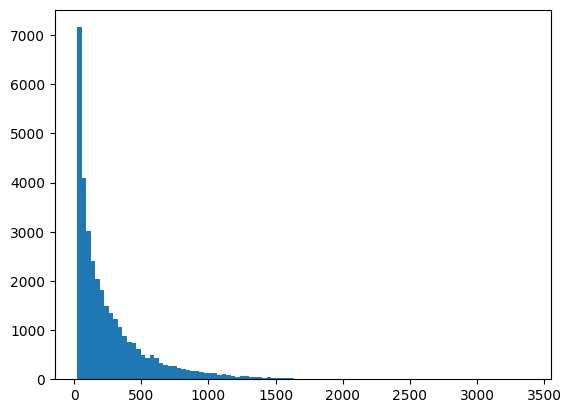

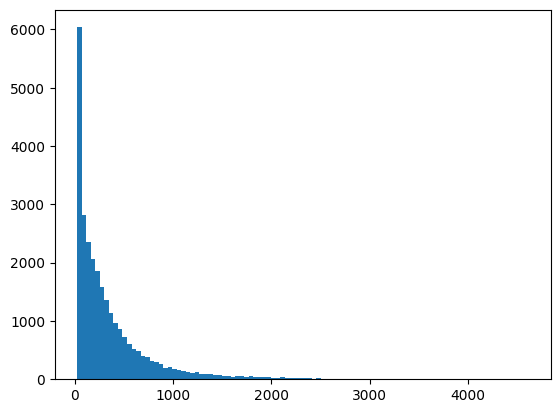

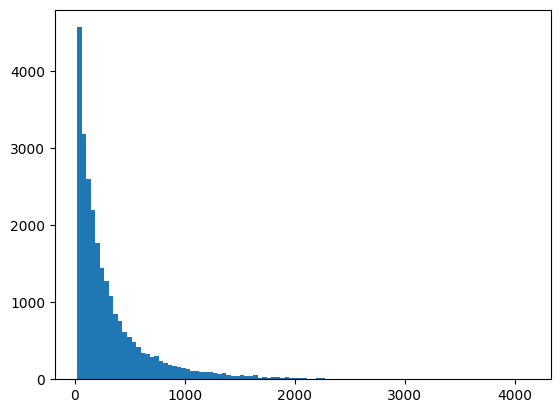

In [15]:
ad_F12ov, aF12ov_pucks, ad_F12ov_adatas = load_sample_pucks('F12ov', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Old',
                                       'Batch':'Buck'})
ad_F12ov

Loading puck Puck_230913_06
(11379, 17557)
Loading puck PM104_001
(16159, 18813)
Loading puck Puck_230807_03
(15064, 19459)
Loading puck Puck_240108_03
(11763, 14515)
Loading puck Puck_240108_07
(14739, 18431)
13958 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(35983, 21855)


AnnData object with n_obs × n_vars = 35983 × 21855
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-3', 'mt-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'n_cells-4', 'mt-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

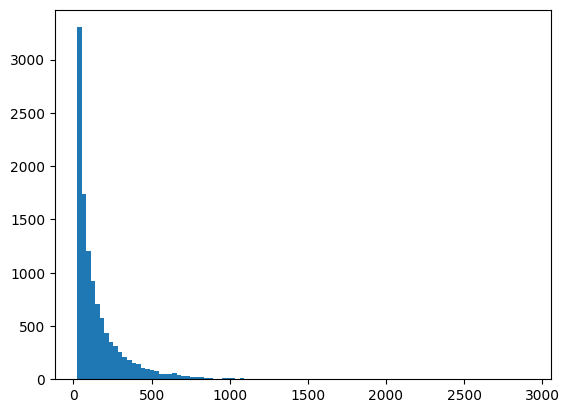

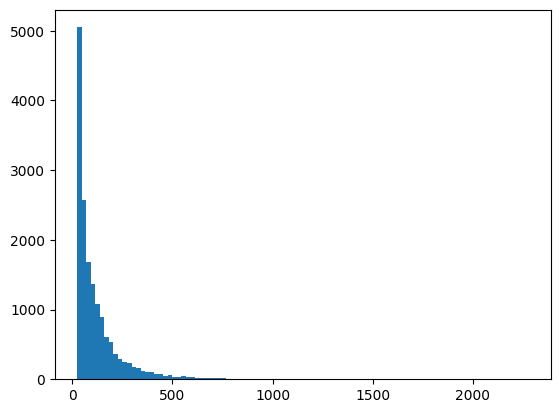

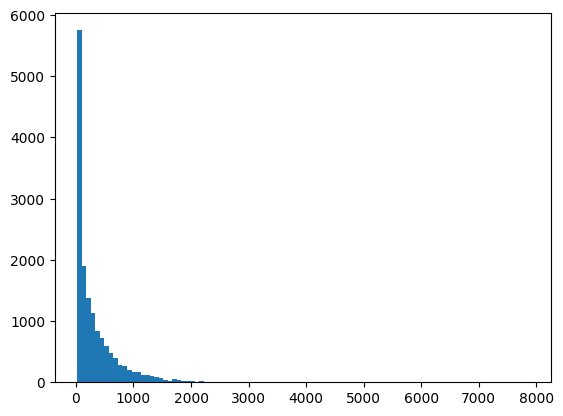

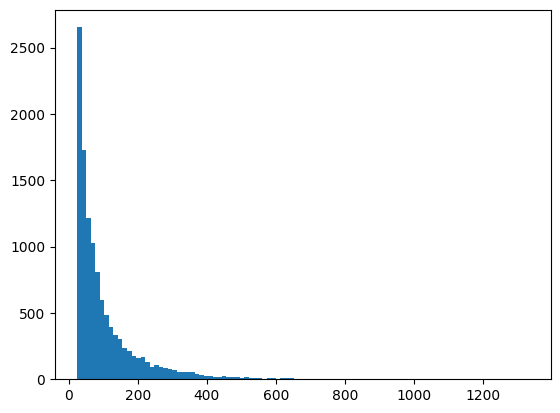

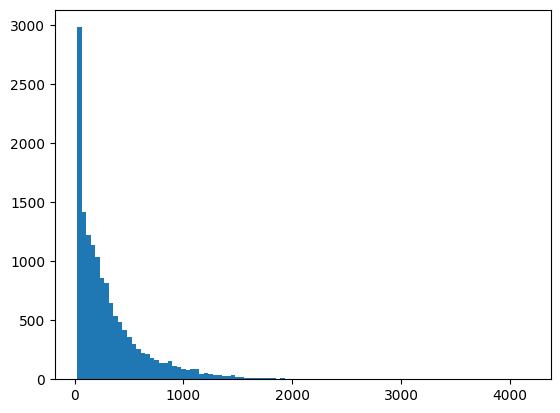

In [16]:
ad_1OE, a1OE_pucks, ad_1OE_adatas= load_sample_pucks('1OE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Old',
                                       'Batch':'Broad2'})
ad_1OE

Loading puck A0029_028
(25409, 18087)
Loading puck Puck_240129_21
(23053, 20644)
Loading puck Puck_240129_22
(33216, 20785)
Loading puck Puck_240129_23
(23971, 19629)
16505 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(58195, 22701)


AnnData object with n_obs × n_vars = 58195 × 22701
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-3', 'mt-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

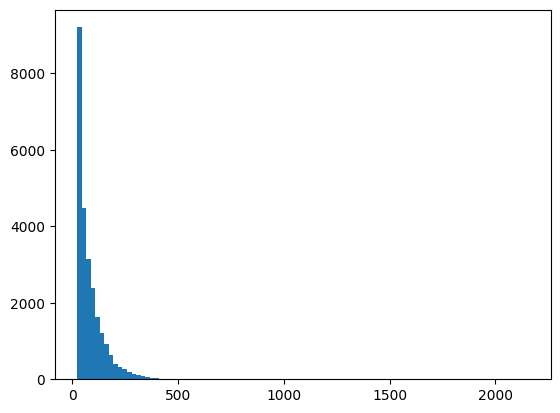

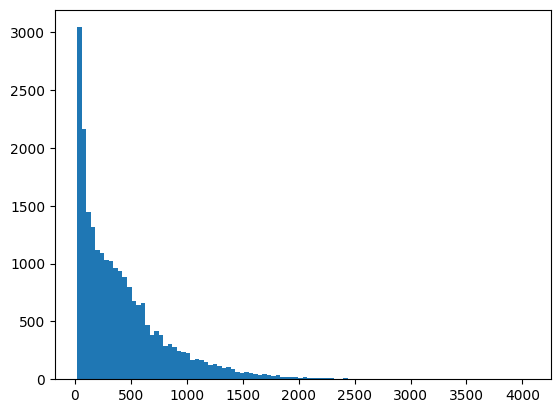

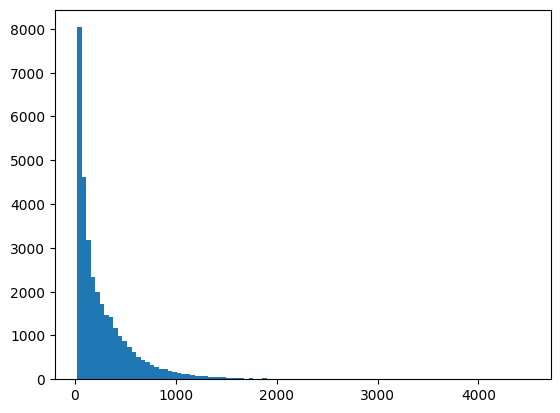

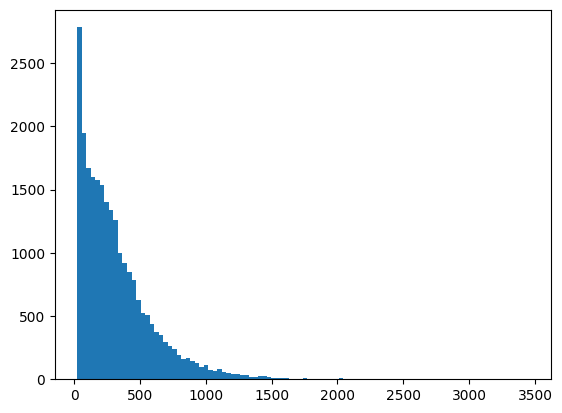

In [17]:
ad_2OM, a2OM_pucks, ad_2OM_adatas= load_sample_pucks('2OM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Old',
                                       'Batch':'Broad2'})
ad_2OM

Loading puck A0029_035
(13472, 18354)
Loading puck Puck_240108_14
(9879, 18678)
Loading puck Puck_240108_16
(12185, 18031)
Loading puck Puck_240108_17
(9563, 17742)
15509 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(26675, 21286)


AnnData object with n_obs × n_vars = 26675 × 21286
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-3', 'mt-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

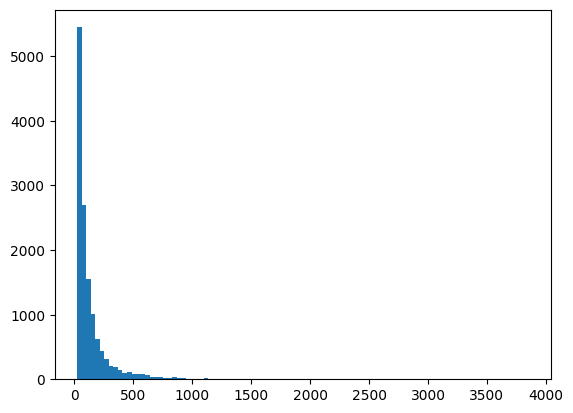

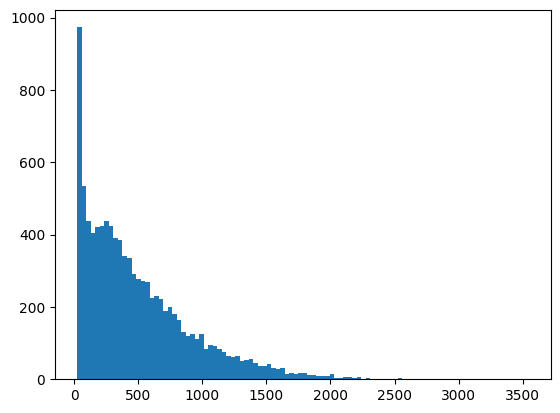

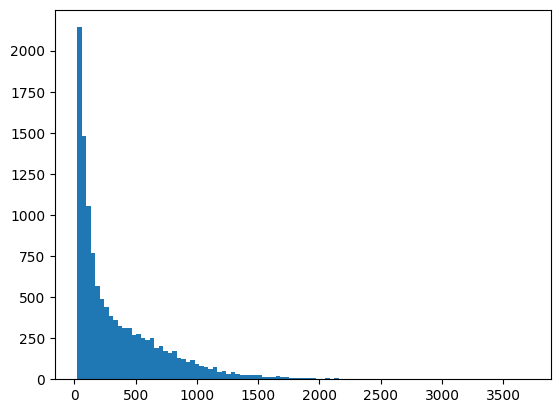

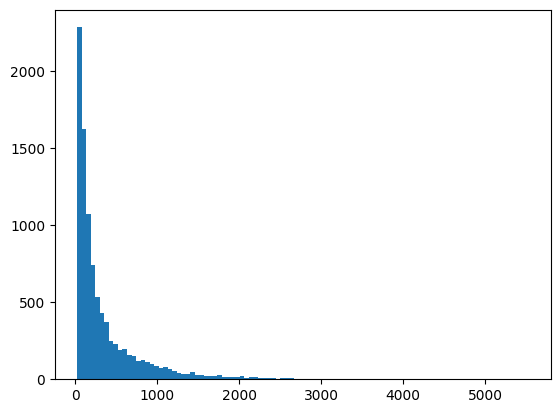

In [18]:
ad_3OE, a3OE_pucks, ad_3OE_adatas= load_sample_pucks('3OE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Old',
                                       'Batch':'Broad2'})
ad_3OE

Loading puck Puck_240129_27
(25611, 18885)
Loading puck Puck_240129_29
(26785, 18608)
17810 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(26522, 19683)


AnnData object with n_obs × n_vars = 26522 × 19683
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

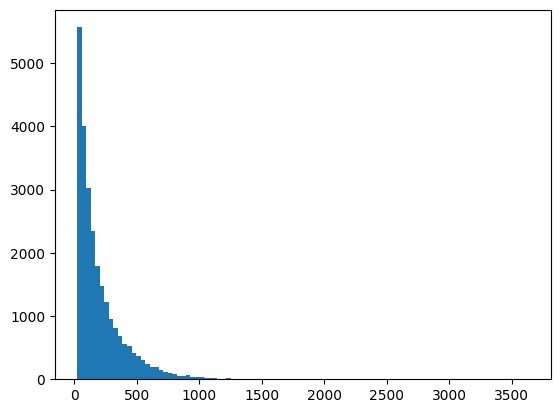

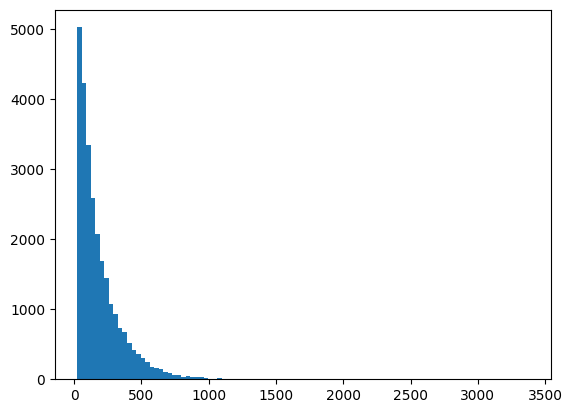

In [19]:
ad_4OM, a4OM_pucks, ad_4OM_adatas= load_sample_pucks('4OM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Old',
                                       'Batch':'Broad2'})
ad_4OM

Loading puck Puck_230810_06
(21501, 20695)
20695 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(14221, 20695)


AnnData object with n_obs × n_vars = 14221 × 20695
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

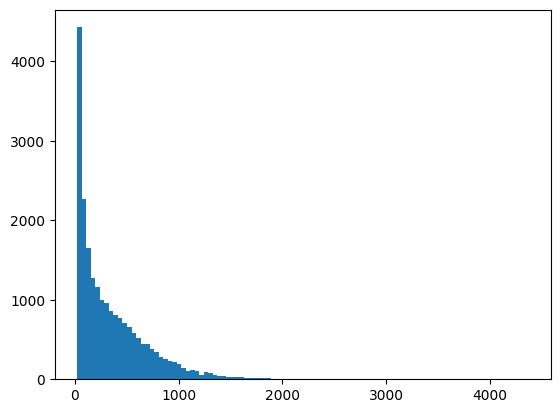

In [20]:
ad_21OE, a21OE_pucks, ad_21OE_adatas= load_sample_pucks('21OE', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Estrus',
                                       'Age':'Old',
                                       'Batch':'Broad1'})
ad_21OE

Loading puck Puck_230810_08
(24465, 20654)
Loading puck Puck_230810_11
(19907, 19203)
18444 intersecting genes


/tmp/ipykernel_7922/3487854072.py:50: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad_concat = adatas[0].concatenate(adatas[1:], join='outer', fill_value = 0)


(22651, 21413)


AnnData object with n_obs × n_vars = 22651 × 21413
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    var: 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1'
    uns: 'log1p'
    obsm: 'spatial'
    layers: 'counts'

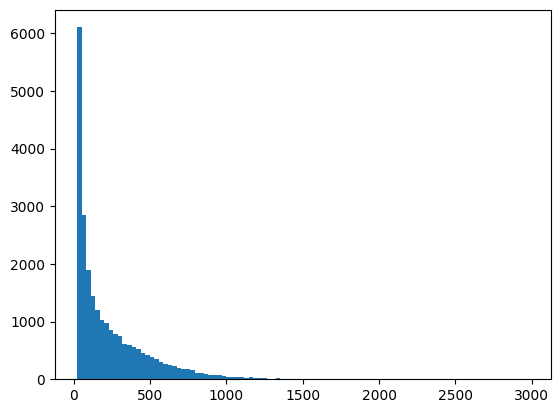

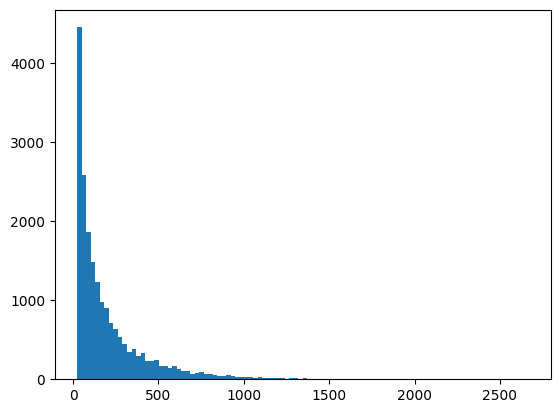

In [21]:
ad_25OM, a25OM_pucks, ad_25OM_adatas= load_sample_pucks('25OM', sample_dict, '../data',
                             min_cts=150, min_genes=50,
                             metadata={'Stage':'Metestrus',
                                       'Age':'Old',
                                       'Batch':'Broad1'})
ad_25OM

## concat old ('join = outer')

In [22]:
ad_old_r = anndata.concat([ad_F12ov, 
                           ad_1OE, 
                           ad_3OE, 
                           ad_2OM, 
                           ad_4OM, 
                           ad_21OE, 
                           ad_25OM],
                          join= 'outer', fill_value= 0)
ad_old_r.obs_names_make_unique()
ad_old_r

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 239485 × 25660
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Stage', 'Age', 'Batch', 'batch', 'n_counts'
    obsm: 'spatial'
    layers: 'counts'

In [ ]:
#ad_young.write('%s/240303_young_raw.h5ad' %analysis, compression = 'gzip')
#ad_middle.write('%s/middle_240219_processed.h5ad' %analysis, compression = 'gzip')
ad_old_r.write('%s/240327_old_raw.h5ad' %analysis, compression = 'gzip') #~13m, 1GB

# smear removal

In [ ]:
ad_young_r = anndata.read('%s/240327_young_raw.h5ad' %analysis)
ad_middle_r = anndata.read('%s/240327_middle_raw.h5ad' %analysis)
ad_old_r = anndata.read('%s/240327_old_raw.h5ad' %analysis)

# Remove smears

## Young

In [23]:
print_puck_list(ad_young_r_cropped)

1 A0029_036
2 A0029_042
3 A0029_043
4 A0029_047
5 A0064_039
6 PM104_004
7 Puck_230223_01
8 Puck_230406_01
9 Puck_230406_06
10 Puck_230406_08
11 Puck_230517_37
12 Puck_230517_38
13 Puck_230517_39
14 Puck_230714_23
15 Puck_230714_28
16 Puck_230714_29
17 Puck_230807_04
18 Puck_230807_27
19 Puck_230913_07
20 Puck_240108_10
21 Puck_240108_11
22 Puck_240108_20
23 Puck_240108_24
24 Puck_240108_25
25 Puck_240108_26
26 Puck_240108_27
27 Puck_240108_32
28 Puck_240108_33
29 Puck_240108_35
30 Puck_240129_36
31 Puck_240129_37


In [24]:
filtered_pucks_young = []  # do we need this?
filtered_spots_young = []

### Puck [1]

In [25]:
puck_id = "A0029_036"
ad_puck = get_puck_cropping(ad_young_r, puck_id)
color_dict = dict(zip(list(ad_puck.obs['leiden'].cat.categories), twenty_colors_palette))
ad_puck.obs['leiden_color'] 

% visual smear removal 

In [7]:
# %matplotlib widget
# if __name__ == '__main__':
#     subplot_kw = dict(xlim=(0, 6000), ylim=(0, 6000), autoscale_on=False)
#     fig, ax = plt.subplots(subplot_kw=subplot_kw,figsize=(10,10) )

#     # Plot all counts
#     values = list(ad_puck.obs['leiden_color']) # You can put in your cluster identities here
#     # x = list(test.obs['x_um'])
#     # y = list(test.obs['y_um'])
#     x = list([pair[0] for pair in ad_puck.obsm['spatial']])
#     y = list([pair[1] for pair in ad_puck.obsm['spatial']])

#     pts = ax.scatter(x, y, s=2, 
#                      c=values, 
#                      vmax=400)
#     selector = SelectFromCollection(ax, pts)

#     def accept(event):
#         if event.key == "enter":
#             print("Selected points:")
#             print(selector.xys[selector.ind])
#             selector.disconnect()
#             ax.set_title("")
#             fig.canvas.draw()

#     fig.canvas.mpl_connect("key_press_event", accept)
#     ax.set_title("Press enter to accept selected points.")

#     plt.show()

In [ ]:
# ToDo not sure what column this selection is saved in:
filtered_spots_young.append(ad_puck.obs_names[ad_puck.obs["some columns"].values == "some value"])

## Middle

In [23]:
print_puck_list(ad_middle_r_cropped)

1 A0029_036
2 A0029_042
3 A0029_043
4 A0029_047
5 A0064_039
6 PM104_004
7 Puck_230223_01
8 Puck_230406_01
9 Puck_230406_06
10 Puck_230406_08
11 Puck_230517_37
12 Puck_230517_38
13 Puck_230517_39
14 Puck_230714_23
15 Puck_230714_28
16 Puck_230714_29
17 Puck_230807_04
18 Puck_230807_27
19 Puck_230913_07
20 Puck_240108_10
21 Puck_240108_11
22 Puck_240108_20
23 Puck_240108_24
24 Puck_240108_25
25 Puck_240108_26
26 Puck_240108_27
27 Puck_240108_32
28 Puck_240108_33
29 Puck_240108_35
30 Puck_240129_36
31 Puck_240129_37


In [24]:
filtered_pucks_middle = []  # do we need this?
filtered_spots_middle = []

## Old

In [23]:
print_puck_list(ad_old_r_cropped)

1 A0029_036
2 A0029_042
3 A0029_043
4 A0029_047
5 A0064_039
6 PM104_004
7 Puck_230223_01
8 Puck_230406_01
9 Puck_230406_06
10 Puck_230406_08
11 Puck_230517_37
12 Puck_230517_38
13 Puck_230517_39
14 Puck_230714_23
15 Puck_230714_28
16 Puck_230714_29
17 Puck_230807_04
18 Puck_230807_27
19 Puck_230913_07
20 Puck_240108_10
21 Puck_240108_11
22 Puck_240108_20
23 Puck_240108_24
24 Puck_240108_25
25 Puck_240108_26
26 Puck_240108_27
27 Puck_240108_32
28 Puck_240108_33
29 Puck_240108_35
30 Puck_240129_36
31 Puck_240129_37


In [24]:
filtered_pucks_old = []  # do we need this?
filtered_spots_old = []

# Subset objects

In [ ]:
ad_young_r_cropped = ad_young_r_cropped[[
    x not in filtered_spots_young for x in ad_young_r_cropped.obs_names
]]

In [ ]:
ad_middle_r_cropped = ad_young_r_cropped[[
    x not in filtered_spots_middle for x in ad_middle_r_cropped.obs_names
]]

In [ ]:
ad_old_r_cropped = ad_young_r_cropped[[
    x not in filtered_spots_old for x in ad_old_r_cropped.obs_names
]]

# Save modified objects

In [ ]:
pickle.dump(filtered_spots_young, open('%s/240327_filtered_spots_young.pickle', "wb" ) )
pickle.dump(filtered_spots_middle, open('%s/240327_filtered_spots_middle.pickle', "wb" ) )
pickle.dump(filtered_spots_old, open('%s/240327_filtered_spots_old.pickle', "wb" ) )

In [ ]:
ad_young_r_cropped.write('%s/240327_young_raw_cropped.h5ad' %analysis, compression = 'gzip')
ad_middle_r_cropped.write('%s/240327_middle_raw_cropped.h5ad' %analysis, compression = 'gzip')
ad_old_r_cropped.write('%s/240327_old_raw_cropped.h5ad' %analysis, compression = 'gzip')

# Concatenate filtered data

In [ ]:
ad_young = pickle.load(open('%s/240328_filtered_spots_young.pickle' % analysis, "rb" ) )
ad_middle = pickle.load(open('%s/240328_filtered_spots_middle.pickle' % analysis, "rb" ) )
ad_old = pickle.load(open('%s/240328_filtered_spots_old.pickle' % analysis, "rb" ) )#

In [ ]:
ad_young_for_merging = ad_young.raw.to_adata()
ad_young_for_merging.obs = ad_young.obs
ad_young_for_merging.uns = ad_young.uns

ad_middle_for_merging = ad_middle.raw.to_adata()
ad_middle_for_merging.obs = ad_middle.obs
ad_middle_for_merging.uns = ad_middle.uns

ad_old_for_merging = ad_old.raw.to_adata()
ad_old_for_merging.obs = ad_old.obs
ad_old_for_merging.uns = ad_old.uns

ad_concat = anndata.concatenate(
    [ad_young_for_merging, ad_middle_for_merging, ad_old_for_merging], 
    join='outer', 
    fill_value = 0
)

ad_concat.layers['counts'] = ad_concat.X.copy()
ad_concat.raw = ad_concat

# Clustering

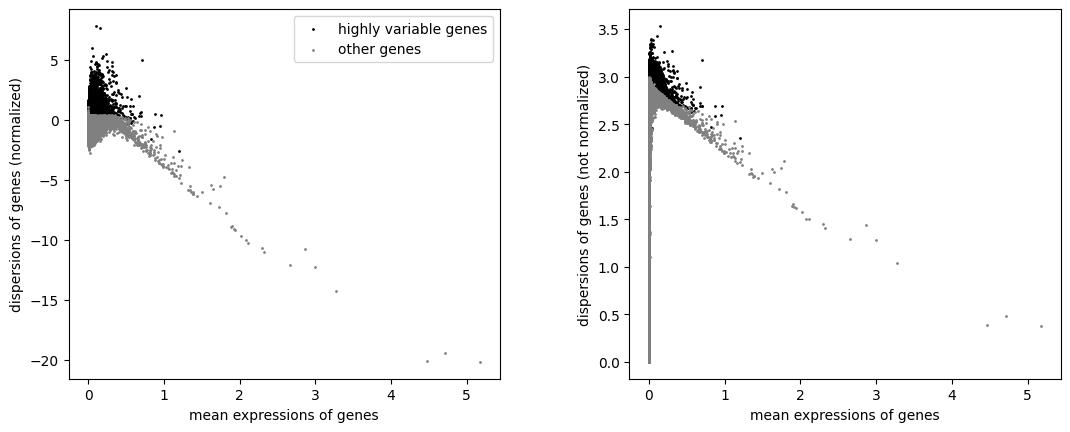

5000 of 27303 genes called variable
Regressing out counts


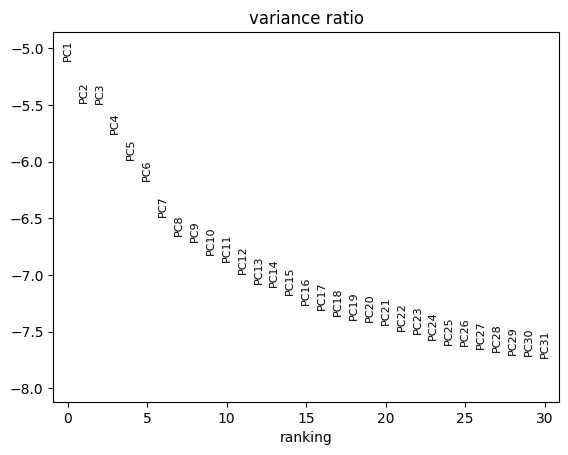

2024-04-24 21:24:25,542 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-24 21:27:54,772 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-24 21:27:57,577 - harmonypy - INFO - Iteration 1 of 10
2024-04-24 21:36:04,729 - harmonypy - INFO - Iteration 2 of 10
2024-04-24 21:44:13,328 - harmonypy - INFO - Converged after 2 iterations
2024-04-24 21:44:18.731115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 21:44:22.296514: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib6

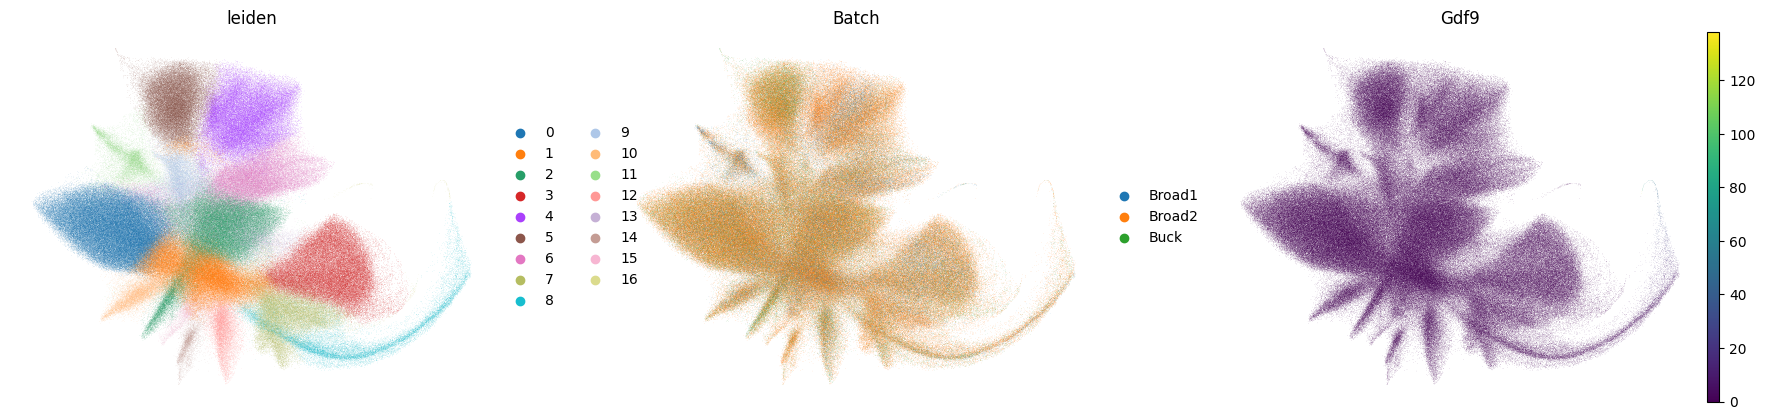

AnnData object with n_obs × n_vars = 601831 × 5000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'puck', 'sample', 'Age', 'Batch', 'batch', 'n_counts', 'leiden', 'leiden_12', 'cell_type', 'leiden_15', 'is_oocyte', 'id_oocyte', 'oocyte_rating', 'is_granulosa', 'granulosa_type', 'id_follicle', 'id_corpusluteum', 'id_proximity_oocyte', 'id_proximity_follicle', 'id_proximity_corpusluteum', 'is_theca', 'id_theca', 'is_mesenchyme', 'id_mesenchyme', 'is_immune', 'id_immune', 'stromal_immune', 'is_vascular', 'id_vascular', 'stromal_vascular', 'is_epithelium', 'id_epithelium', 'matched_epithelium', 'id_oocyte_matched', 'segment_id', 'segment_id_core', 'segment_layer', 'segment_has_oocyte', 'mouse', 'stage', 'segment_cluster', 'segment_type'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'corpusluteum_centers', 'follicle_centers', 'log1p', 'oo

In [9]:
#compute umap, no scaling, just to check me and david's agreement of clusters
adata = harmony_cluster_recipe(ad_concat, leiden_res=1.5)
adata

In [ ]:
#leiden DEG
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxen', key_added = 'rank_genes_groups', use_raw = True)
sc.pl.rank_genes_groups(adata, key='rank_genes_groups', n_genes=20, sharey=False)
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
marker_genes.head(15)

## GC - subcluster

In [ ]:
#Cell types to include
cell_types_to_include = [
    '7','8','11','18','21']

#Subset AnnData object to exclude the specified cell types
ad_sub = adata[adata.obs['leiden'].isin(cell_types_to_include), :].copy()

# Plot the UMAP
sc.pl.umap(ad_sub, color=['leiden', 'cell_type', 'total_counts'])


In [ ]:
# #recalculate pcas on this cluster
sc.pp.neighbors(ad_sub, n_neighbors=10, n_pcs=40, use_rep='X_pca_harmony')
sc.tl.umap(ad_sub)
sc.tl.leiden(ad_sub, resolution=0.7, key_added = 'leiden_foll')
sc.pl.umap(ad_sub, color=['leiden_foll','new_annot_foll', 'leiden', 'Cyp11a1', 'Star'], ncols = 3, use_raw =True, frameon=False)

In [ ]:
#leiden DEG
sc.tl.rank_genes_groups(ad_sub, 'leiden_sub', method='wilcoxen', key_added = 'rank_genes_groups', use_raw = True)
sc.pl.rank_genes_groups(ad_sub, key='rank_genes_groups', n_genes=20, sharey=False)
marker_genes = pd.DataFrame(ad_sub.uns['rank_genes_groups']['names'])
marker_genes.head(15)

# Cell type annotation

In [ ]:
##annotate these leiden
cell_type_dict = {
    '0': 'Stromal - nonsteroidogenic',
    '1': 'Luteal - late',
    '2': 'Stromal - nonsteroidogenic',
    '3': 'Stromal - steroidogenic',
    '4': 'Muscle',
    '5': 'Luteal - early',
    '6': 'Immune',
    '7': 'GC',
    '8': 'GC',
    '9': 'Endothelial - vascular',
    '10': 'Fibroblast',
    '11': 'GC',
    '12': 'Oocyte - cumulus',
    '13': 'Endothelial - lymphatic',
    '14': 'Endothelial - blood',
    '15': 'Epithelial - surface',
    '16': 'Theca',
    '17': 'Oocyte',
    '18': 'GC',
    '19': 'Adipocyte',  
    '20': 'Epithelial - oviduct',  
    '21': 'GC',  
    '22': 'Luteal - early',
    '23': 'Endothelial - blood',
    '24': 'Stromal - steroidogenic',
}

adata.obs['cell_type'] = adata.obs['leiden'].map(cell_type_dict)

In [ ]:
#GC subcluster
cell_type_dict = { 
    '0': 'GC - antral mitotic',
    '1': 'GC - antral luteinizing',
    '2': 'GC - antral mitotic',
    '3': 'GC - atretic',
    '4': 'GC - antral early mitotic',
    '5': 'GC - preantral',
    '6': 'GC - antral mitotic',
    '7': 'GC - antral mitotic',
    }


ad_sub.obs['annot_foll'] = ad_sub.obs['leiden_foll'].map(cell_type_dict)
sc.pl.umap(ad_sub, color=['leiden_foll', 'annot_foll'], #groups = ['5'],
           ncols = 3, use_raw =True, frameon=False)

In [ ]:
# reannoatate
adata.obs['cell_type'] = adata.obs['cell_type'].astype(str)
# Ensure indices between adata and ad_sub are aligned
common_indices = adata.obs.index.intersection(ad_test.obs.index)

# Update only the common indices in adata with the values from ad_sub
adata.obs.loc[common_indices, 'cell_type'] = ad_sub.obs.loc[common_indices, 'annot_foll']
sc.pl.umap(adata, color=['cell_type','leiden'], #groups =['Oocyte - contaminated'],
           ncols = 3, vmax = 1,
           use_raw =True, wspace = 0.5, frameon=False, palette = custom_palette)

In [ ]:
marker_genes = {
    'Oocyte': ["Gdf9", "H1f8"],
    'Cumulus - oocyte': [],
    'GC - preantral': ["Kctd14", "Slc18a2"],
    'GC - antral early mitotic': ["Rgs2", "Ccnd2"],
    'GC - antral mitotic': ["Serpine2", "Inhbb"],
    'GC - antral luteinizing': ["Fst", "Cyp19a1"],
    'GC - atretic': ['Cfh','Pik3r1'], 
    'Luteal - early': ['Fdx1', 'Lhcgr'], 
    'Luteal - late': ['Sfrp4', 'Akr1c18'], 
    'Theca': ["Cyp17a1", "Col1a2"], 
    'Endothelial - blood': ["Hbb-bs", "Hba-a1"], 
    'Endothelial - lymphatic': ["Ccl21a", "Lyve1"], 
    'Endothelial - vascular': ["Flt1", "Igfbp7"],  
    'Epithelial - surface': ['Lgals7', 'Epcam'],
    'Epithelial - oviduct': ['Ovgp1', 'Gsto1'], 
    'Immune': ["Lyz2", "Ctss"], 
    'Muscle': ["Tagln", "Myh11"], 
    'Fibroblast': ["Pdgfra", "Dcn"],
    'Stromal - nonsteroidogenic': ['Dync1i1', 'Kcnd2'],
    'Stromal - steroidogenic': ["Mgarp", "Star"], 
    'Adipocyte': ["Fabp4", "Adipoq"],
}

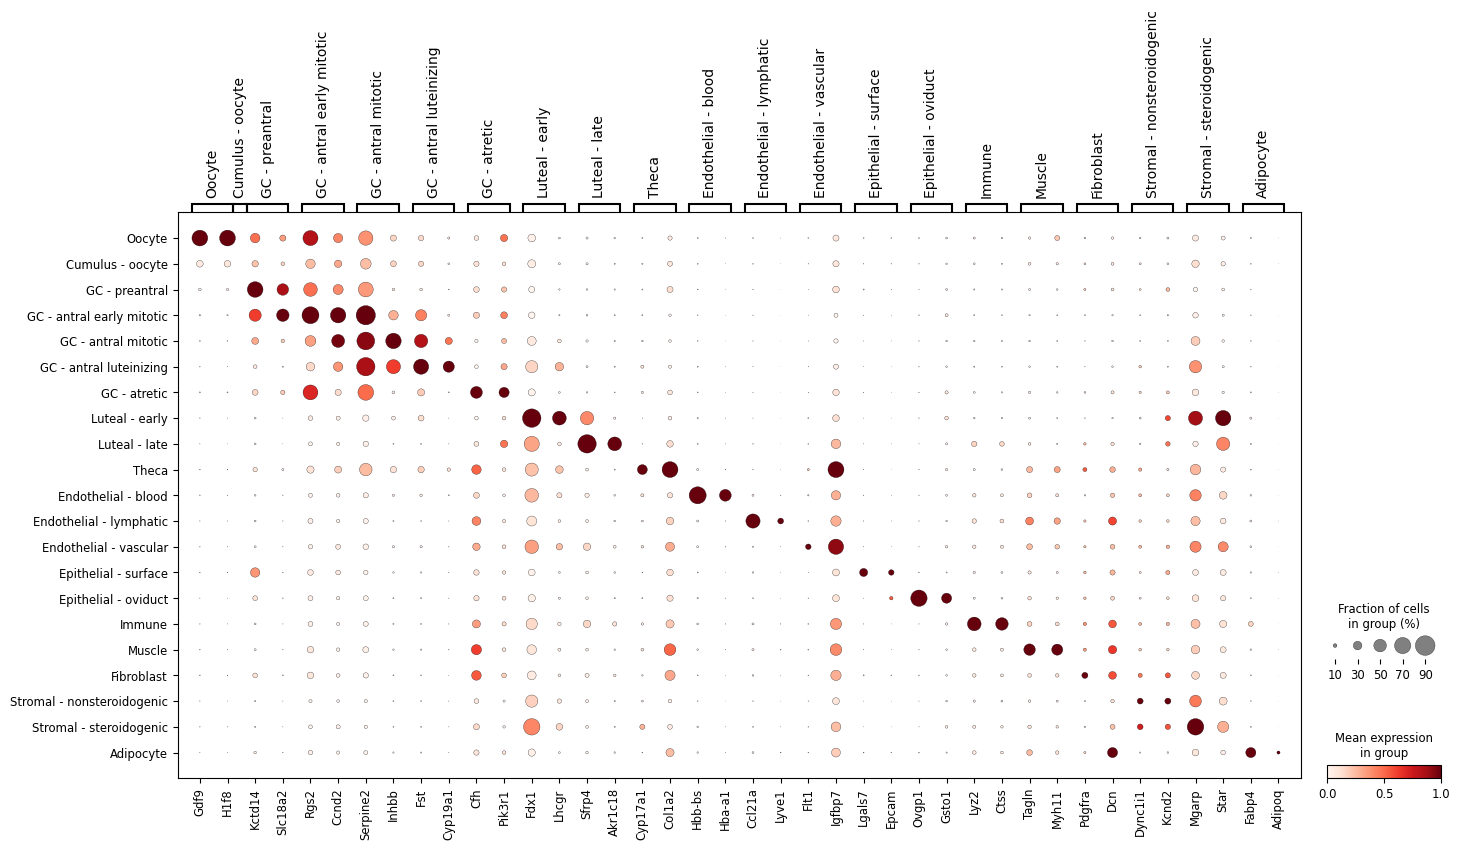

In [37]:
# DEG
sc.pl.dotplot(adata, marker_genes, groupby='cell_type', standard_scale="var",
              #save="dotplot_marker_genes.pdf"
             )
